In [2]:
import torch
import torch.nn as nn
from d2l import torch as d2l

# AlexNet
> 从 `AlexNet` 只考虑网络结构以及实现, 不考虑背景

## AlexNet网络结构
`AlexNet`网络结构如下:
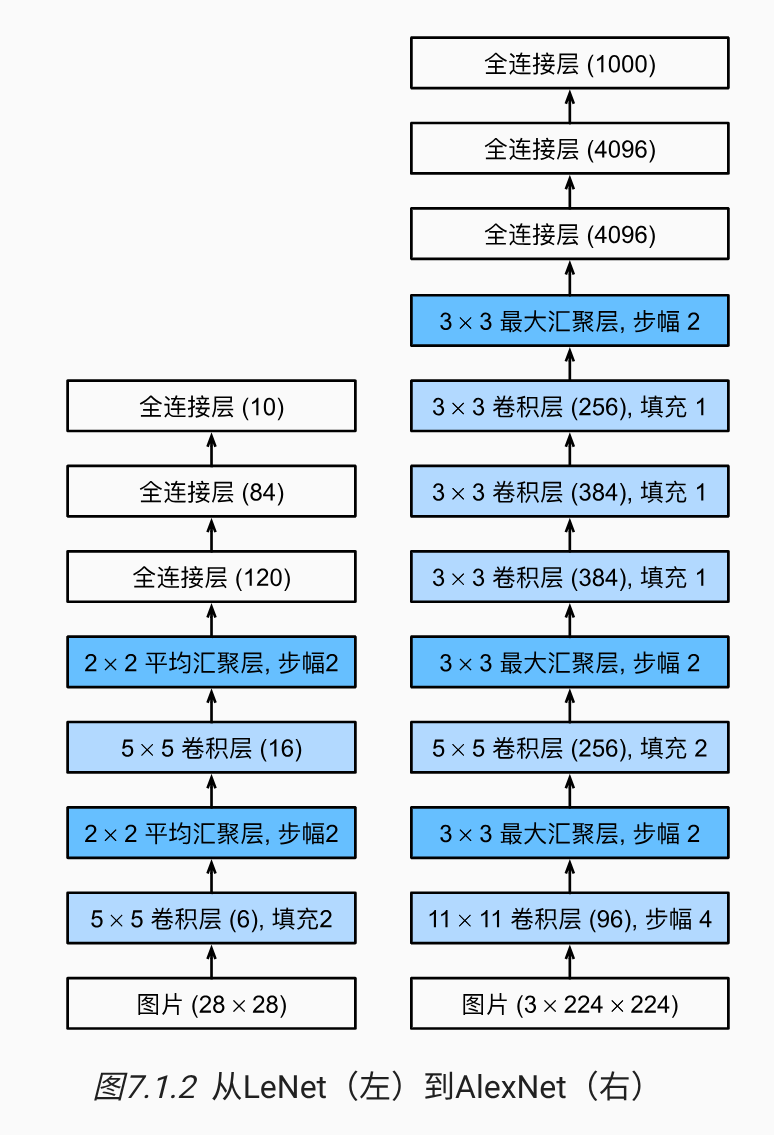
可以发现 `AlexNet` 比 `LeNet` 更深, 并且由 8 个层组成, 同时使用 `ReLU` 作为激活函数(防止梯度消失), 同时 `AlexNet` 解决的问题是 `ImageNet` 中的 `1000` 分类问题

In [5]:
# AlexNet 网络结构
# 图片尺寸大小 3*224*224 -> 只需要考虑一个特征
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, padding=2, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), # 这里的层数需要注意
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10)
)

In [6]:
X = torch.rand(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, '\toutput shape:\t', X.shape)

Conv2d 	output shape:	 torch.Size([1, 96, 54, 54])
ReLU 	output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d 	output shape:	 torch.Size([1, 96, 26, 26])
Conv2d 	output shape:	 torch.Size([1, 256, 26, 26])
ReLU 	output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d 	output shape:	 torch.Size([1, 256, 12, 12])
Conv2d 	output shape:	 torch.Size([1, 384, 12, 12])
ReLU 	output shape:	 torch.Size([1, 384, 12, 12])
Conv2d 	output shape:	 torch.Size([1, 384, 12, 12])
ReLU 	output shape:	 torch.Size([1, 384, 12, 12])
Conv2d 	output shape:	 torch.Size([1, 256, 12, 12])
ReLU 	output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d 	output shape:	 torch.Size([1, 256, 5, 5])
Flatten 	output shape:	 torch.Size([1, 6400])
Linear 	output shape:	 torch.Size([1, 4096])
ReLU 	output shape:	 torch.Size([1, 4096])
Dropout 	output shape:	 torch.Size([1, 4096])
Linear 	output shape:	 torch.Size([1, 4096])
ReLU 	output shape:	 torch.Size([1, 4096])
Dropout 	output shape:	 torch.Size([1, 4096])
Linear 	output s

In [3]:
batch_size=128 # 注意调整大小
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size,resize=224)

In [4]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    device_count = torch.cuda.device_count()
    if device_count > 1:
        net = nn.DataParallel(net)
        net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## AlexNet 模型训练

In [ ]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

training on cpu


使用 `cpu` 无法对于模型进行训练, 所以这里使用 `kaggle` 上提供的 `GPU` 训练模型, 训练结果如下:
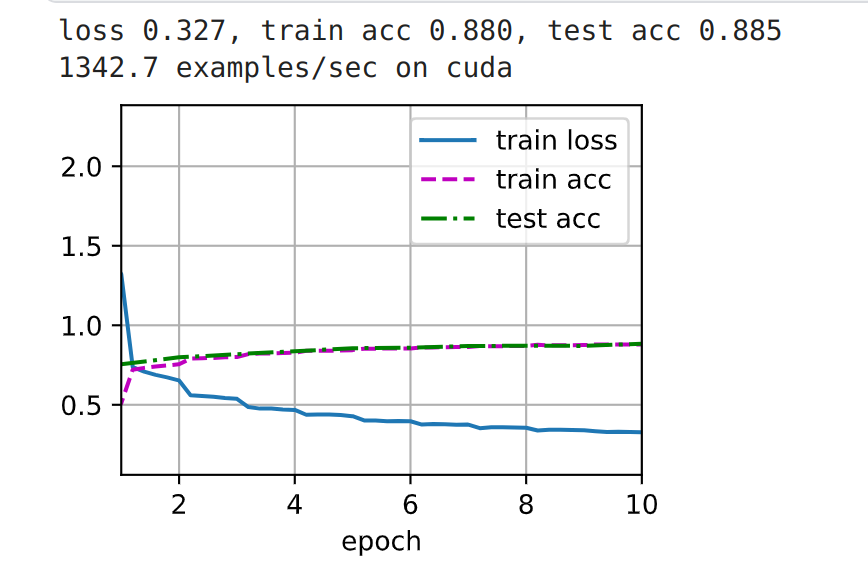